# Mongolian Forced Aligner with Tacotron and aeneas

Given an audio file containing speech, and the corresponding transcript, computing a forced alignment is the process of determining, for each fragment of the transcript, the time interval (in the audio file) containing the spoken text of the fragment.

Typical applications of forced alignment include closed captioning and automating the creation of training data for **automated speech recognition** and **text-to-speech** systems.

For more information about forced alignment tools, see [pettarin/forced-alignment-tools](https://github.com/pettarin/forced-alignment-tools)

Currently, there is no Mongolian forced aligner tool. This is the first attempt to implement a forced aligner for the Mongolian language using [Rayhane-mamah/Tacotron-2](https://github.com/Rayhane-mamah/Tacotron-2) and [readbeyond/aeneas](https://github.com/readbeyond/aeneas).

For implementation details, visit [tugstugi/mongolian-nlp/forced_aligner](https://github.com/tugstugi/mongolian-nlp/tree/master/forced_aligner)

## Setup

In [0]:
%tensorflow_version 1.x
import os, pathlib, json
from os.path import exists, join, expanduser

import IPython
from IPython.display import YouTubeVideo, Audio, clear_output, display

### Install aeneas

In [0]:
# aeneas needs espeak
!apt-get install -qq libespeak-dev > /dev/null
# aeneas must be installed from the devel branch
!pip install -q https://codeload.github.com/readbeyond/aeneas/zip/devel

### Install Tacotron-2

In [0]:
# pyaudio needs this system dependency!
!apt-get install -qq portaudio19-dev > /dev/null
# clone Tacotron-2 and install dependencies
if not exists('Tacotron-2'):
  !git clone https://github.com/tugstugi/Tacotron-2.git && cd Tacotron-2 && pip install -q -r requirements.txt

### Download a pretrained Tacotron-2 model

In [0]:
if not exists('Tacotron-2/logs-Tacotron/taco_pretrained'):
  # download pretrained model from the Google Drive link
  pretrained_file_id = "1fgx0kpf0Oe2Idz3lUZM6-p343nc-24Hq"
  pretrained_file_name = "taco_pretrained.tar.gz"
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$pretrained_file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$pretrained_file_id" -o $pretrained_file_name
  # extract it
  !mkdir Tacotron-2/logs-Tacotron/
  !tar xvfz $pretrained_file_name --directory Tacotron-2/logs-Tacotron/

### Download the Tacotron-2 wrapper for aeneas

In [0]:
if not exists('aeneas-helper.py'):
  !pip install -q youtube-dl pydub
  !curl https://raw.githubusercontent.com/tugstugi/mongolian-nlp/master/forced_aligner/aeneas-helper.py > aeneas-helper.py
  !curl https://raw.githubusercontent.com/tugstugi/mongolian-nlp/master/forced_aligner/aeneas-helper.sh > aeneas-helper.sh
  !chmod a+x aeneas-helper.sh

## Forced Aligner Demo

As a demo, we will force align a speech of the Mongolian president Battulga:

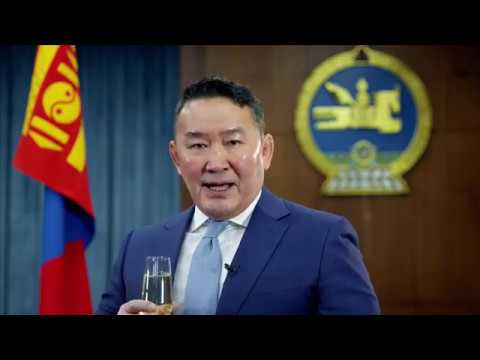

In [6]:
YouTubeVideo(id='x3OiZ4lj5vs', width=600, height=300)

We will download the above video and extract the audio from 00:10s to 00:29s into a file **battulga.mp3**:

In [7]:
!youtube-dl --quiet --extract-audio --audio-format mp3 -o "download.%(ext)s" https://www.youtube.com/watch?v=x3OiZ4lj5vs
!ffmpeg -loglevel panic -y -ss 10.6 -t 18.8 -i download.mp3 battulga.mp3
import pydub
audio = pydub.AudioSegment.from_mp3('battulga.mp3')
# show the audio
audio

The text of the above speech is copied from [https://president.mn/7314/](https://president.mn/7314/) and written into a file **battulga.txt**:

In [0]:
SENTENCES = [
  "Монгол Улсын дөрвөн зүг, найман зовхист амьдран суугаа хүндэт ард иргэд ээ.",
  "Даян дэлхийд тархан суурьшсан Монгол туургатнууд аа.",
  "Он солигдох торгон мөч ирлээ.",
  "Монголчууд бид гурав дахь мянганы арван наймдах оноо үдэж,",
  "ирээдүйгээ дархлан бүтээх хоёр мянга арван есөн оныг угтаж байна."
]
SENTENCES = "\n".join(SENTENCES)
!echo "$SENTENCES" > battulga.txt

Now, we will force align the audio **battulga.mp3** with the text file **battulga.txt** and write out the result into a file **result.json**. If you are using Colab and it takes too long, change your Runtime type to **GPU**.

In [0]:
!python -m aeneas.tools.execute_task -r="tts=custom|tts_path=./aeneas-helper.py" \
    battulga.mp3 battulga.txt \
    "task_language=mon|os_task_file_format=json|is_text_type=plain" \
    result.json

Read now the **result.json** file and show it nicely:

In [10]:
for fragment in json.loads(pathlib.Path('result.json').read_text())['fragments']:
    start = int(float(fragment['begin'])*1000)
    end = int(float(fragment['end'])*1000)
    text = fragment['lines'][0]
    print(text)
    display(audio[start:end])

Монгол Улсын дөрвөн зүг, найман зовхист амьдран суугаа хүндэт ард иргэд ээ.


Даян дэлхийд тархан суурьшсан Монгол туургатнууд аа.


Он солигдох торгон мөч ирлээ.


Монголчууд бид гурав дахь мянганы арван наймдах оноо үдэж,


ирээдүйгээ дархлан бүтээх хоёр мянга арван есөн оныг угтаж байна.
